In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py was referred.

/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte


In [2]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [3]:
### read dataset 
train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
X_train = train[list(train.columns)[1:]].values
gen_imgs = np.array((25, 28, 28, 1))

In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = fashion_mnist.load_data()
        train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
        X_train = train[list(train.columns)[1:]].values

        X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
        
        # Rescale train images -1 to 1
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if (epoch % sample_interval == 0) or (epoch == 2999):
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.656767, acc.: 48.44%] [G loss: 0.556664]


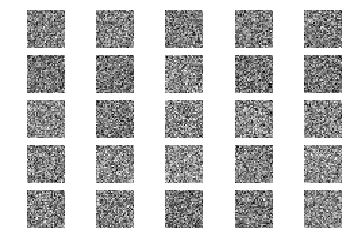

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.429232, acc.: 62.50%] [G loss: 0.585944]
2 [D loss: 0.378249, acc.: 67.19%] [G loss: 0.672059]
3 [D loss: 0.384852, acc.: 68.75%] [G loss: 0.729446]
4 [D loss: 0.340905, acc.: 82.81%] [G loss: 0.813579]
5 [D loss: 0.311031, acc.: 85.94%] [G loss: 1.038887]
6 [D loss: 0.290999, acc.: 90.62%] [G loss: 1.172898]
7 [D loss: 0.231838, acc.: 98.44%] [G loss: 1.328276]
8 [D loss: 0.174662, acc.: 100.00%] [G loss: 1.559681]
9 [D loss: 0.171780, acc.: 96.88%] [G loss: 1.713697]
10 [D loss: 0.114530, acc.: 100.00%] [G loss: 1.846873]
11 [D loss: 0.126095, acc.: 100.00%] [G loss: 1.978921]
12 [D loss: 0.106117, acc.: 100.00%] [G loss: 2.201241]
13 [D loss: 0.096680, acc.: 100.00%] [G loss: 2.376616]
14 [D loss: 0.069940, acc.: 100.00%] [G loss: 2.318239]
15 [D loss: 0.069865, acc.: 100.00%] [G loss: 2.463963]
16 [D loss: 0.067909, acc.: 100.00%] [G loss: 2.587556]
17 [D loss: 0.066911, acc.: 100.00%] [G loss: 2.733182]
18 [D loss: 0.046113, acc.: 100.00%] [G loss: 2.773946]
19 [D los

154 [D loss: 0.145349, acc.: 96.88%] [G loss: 4.705927]
155 [D loss: 0.362303, acc.: 84.38%] [G loss: 3.269444]
156 [D loss: 0.060982, acc.: 98.44%] [G loss: 4.265798]
157 [D loss: 0.233171, acc.: 90.62%] [G loss: 4.505898]
158 [D loss: 0.196115, acc.: 96.88%] [G loss: 5.022872]
159 [D loss: 0.118794, acc.: 98.44%] [G loss: 4.354503]
160 [D loss: 0.182385, acc.: 95.31%] [G loss: 5.067652]
161 [D loss: 0.289471, acc.: 90.62%] [G loss: 3.485390]
162 [D loss: 0.235419, acc.: 85.94%] [G loss: 4.018747]
163 [D loss: 0.122053, acc.: 96.88%] [G loss: 4.197171]
164 [D loss: 0.244703, acc.: 90.62%] [G loss: 3.925560]
165 [D loss: 0.072126, acc.: 100.00%] [G loss: 3.821143]
166 [D loss: 0.213297, acc.: 93.75%] [G loss: 3.787885]
167 [D loss: 0.146420, acc.: 93.75%] [G loss: 4.418290]
168 [D loss: 0.145637, acc.: 95.31%] [G loss: 3.865621]
169 [D loss: 0.052256, acc.: 100.00%] [G loss: 3.992207]
170 [D loss: 0.075486, acc.: 98.44%] [G loss: 3.292778]
171 [D loss: 0.216043, acc.: 92.19%] [G loss: 

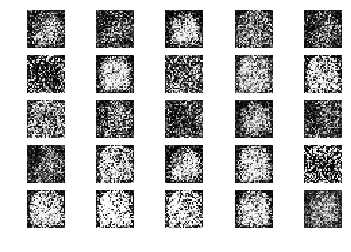

201 [D loss: 0.251622, acc.: 87.50%] [G loss: 3.806689]
202 [D loss: 0.422354, acc.: 82.81%] [G loss: 3.015071]
203 [D loss: 0.294805, acc.: 87.50%] [G loss: 3.738394]
204 [D loss: 0.387950, acc.: 81.25%] [G loss: 3.020731]
205 [D loss: 0.248811, acc.: 89.06%] [G loss: 3.800764]
206 [D loss: 0.242437, acc.: 92.19%] [G loss: 4.289977]
207 [D loss: 0.957242, acc.: 64.06%] [G loss: 2.116760]
208 [D loss: 0.471291, acc.: 75.00%] [G loss: 3.099024]
209 [D loss: 0.155506, acc.: 95.31%] [G loss: 4.462831]
210 [D loss: 0.249265, acc.: 90.62%] [G loss: 3.678511]
211 [D loss: 0.233864, acc.: 90.62%] [G loss: 2.850747]
212 [D loss: 0.162717, acc.: 93.75%] [G loss: 3.547867]
213 [D loss: 0.313471, acc.: 92.19%] [G loss: 2.868392]
214 [D loss: 0.308591, acc.: 87.50%] [G loss: 3.426671]
215 [D loss: 0.472795, acc.: 82.81%] [G loss: 3.378092]
216 [D loss: 0.449262, acc.: 78.12%] [G loss: 2.896615]
217 [D loss: 0.143032, acc.: 96.88%] [G loss: 3.954034]
218 [D loss: 0.441325, acc.: 81.25%] [G loss: 2.

355 [D loss: 0.646627, acc.: 65.62%] [G loss: 1.023925]
356 [D loss: 0.647533, acc.: 65.62%] [G loss: 1.044701]
357 [D loss: 0.688899, acc.: 53.12%] [G loss: 1.121137]
358 [D loss: 0.602571, acc.: 73.44%] [G loss: 1.214022]
359 [D loss: 0.551549, acc.: 71.88%] [G loss: 1.071162]
360 [D loss: 0.630615, acc.: 62.50%] [G loss: 1.111382]
361 [D loss: 0.568066, acc.: 67.19%] [G loss: 1.132215]
362 [D loss: 0.580842, acc.: 70.31%] [G loss: 1.219033]
363 [D loss: 0.601845, acc.: 68.75%] [G loss: 1.078952]
364 [D loss: 0.696717, acc.: 64.06%] [G loss: 1.011122]
365 [D loss: 0.544893, acc.: 73.44%] [G loss: 1.139378]
366 [D loss: 0.574383, acc.: 81.25%] [G loss: 1.088287]
367 [D loss: 0.638508, acc.: 70.31%] [G loss: 1.116019]
368 [D loss: 0.553606, acc.: 71.88%] [G loss: 1.184867]
369 [D loss: 0.633495, acc.: 62.50%] [G loss: 1.125503]
370 [D loss: 0.519231, acc.: 81.25%] [G loss: 1.145920]
371 [D loss: 0.516282, acc.: 75.00%] [G loss: 1.131500]
372 [D loss: 0.598415, acc.: 68.75%] [G loss: 1.

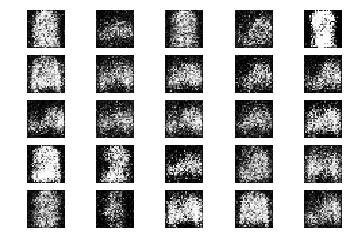

401 [D loss: 0.583650, acc.: 62.50%] [G loss: 1.147475]
402 [D loss: 0.623860, acc.: 70.31%] [G loss: 1.115219]
403 [D loss: 0.565183, acc.: 67.19%] [G loss: 1.252049]
404 [D loss: 0.629081, acc.: 67.19%] [G loss: 1.162276]
405 [D loss: 0.653856, acc.: 64.06%] [G loss: 1.091866]
406 [D loss: 0.648531, acc.: 62.50%] [G loss: 0.969469]
407 [D loss: 0.559343, acc.: 75.00%] [G loss: 1.068296]
408 [D loss: 0.526736, acc.: 73.44%] [G loss: 1.133313]
409 [D loss: 0.516455, acc.: 76.56%] [G loss: 1.104818]
410 [D loss: 0.581679, acc.: 71.88%] [G loss: 1.188865]
411 [D loss: 0.668818, acc.: 64.06%] [G loss: 1.102975]
412 [D loss: 0.606210, acc.: 71.88%] [G loss: 1.053858]
413 [D loss: 0.593306, acc.: 68.75%] [G loss: 1.069431]
414 [D loss: 0.608581, acc.: 73.44%] [G loss: 1.138190]
415 [D loss: 0.648444, acc.: 62.50%] [G loss: 1.035211]
416 [D loss: 0.625224, acc.: 54.69%] [G loss: 1.066035]
417 [D loss: 0.555740, acc.: 76.56%] [G loss: 1.078873]
418 [D loss: 0.711638, acc.: 50.00%] [G loss: 1.

557 [D loss: 0.611036, acc.: 60.94%] [G loss: 1.040061]
558 [D loss: 0.647154, acc.: 62.50%] [G loss: 0.935884]
559 [D loss: 0.624454, acc.: 65.62%] [G loss: 0.940992]
560 [D loss: 0.615853, acc.: 65.62%] [G loss: 0.920286]
561 [D loss: 0.637739, acc.: 62.50%] [G loss: 0.941729]
562 [D loss: 0.668061, acc.: 53.12%] [G loss: 0.983423]
563 [D loss: 0.565946, acc.: 71.88%] [G loss: 1.021085]
564 [D loss: 0.692187, acc.: 59.38%] [G loss: 1.001815]
565 [D loss: 0.658735, acc.: 64.06%] [G loss: 0.933664]
566 [D loss: 0.669290, acc.: 51.56%] [G loss: 0.965045]
567 [D loss: 0.681708, acc.: 50.00%] [G loss: 0.961273]
568 [D loss: 0.663111, acc.: 59.38%] [G loss: 0.984284]
569 [D loss: 0.691338, acc.: 54.69%] [G loss: 0.897516]
570 [D loss: 0.595410, acc.: 65.62%] [G loss: 0.932201]
571 [D loss: 0.664697, acc.: 60.94%] [G loss: 0.851199]
572 [D loss: 0.607316, acc.: 67.19%] [G loss: 0.876931]
573 [D loss: 0.604522, acc.: 67.19%] [G loss: 0.770453]
574 [D loss: 0.680157, acc.: 53.12%] [G loss: 0.

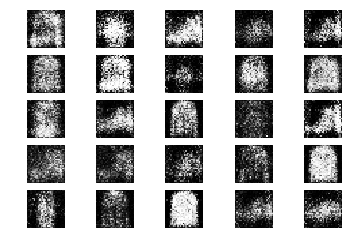

601 [D loss: 0.587719, acc.: 64.06%] [G loss: 0.924240]
602 [D loss: 0.711987, acc.: 56.25%] [G loss: 0.844760]
603 [D loss: 0.547139, acc.: 67.19%] [G loss: 0.856988]
604 [D loss: 0.619829, acc.: 67.19%] [G loss: 1.025951]
605 [D loss: 0.594253, acc.: 65.62%] [G loss: 0.937821]
606 [D loss: 0.585950, acc.: 71.88%] [G loss: 1.027096]
607 [D loss: 0.560422, acc.: 75.00%] [G loss: 0.951647]
608 [D loss: 0.669607, acc.: 46.88%] [G loss: 0.978766]
609 [D loss: 0.661076, acc.: 65.62%] [G loss: 0.972969]
610 [D loss: 0.535522, acc.: 75.00%] [G loss: 0.990818]
611 [D loss: 0.669831, acc.: 54.69%] [G loss: 0.951035]
612 [D loss: 0.673911, acc.: 64.06%] [G loss: 0.915183]
613 [D loss: 0.563031, acc.: 71.88%] [G loss: 0.999056]
614 [D loss: 0.574888, acc.: 70.31%] [G loss: 0.999676]
615 [D loss: 0.699072, acc.: 51.56%] [G loss: 0.958145]
616 [D loss: 0.639534, acc.: 67.19%] [G loss: 0.912017]
617 [D loss: 0.603054, acc.: 57.81%] [G loss: 0.967523]
618 [D loss: 0.672877, acc.: 56.25%] [G loss: 1.

752 [D loss: 0.523602, acc.: 78.12%] [G loss: 0.946928]
753 [D loss: 0.668277, acc.: 67.19%] [G loss: 0.936879]
754 [D loss: 0.673304, acc.: 67.19%] [G loss: 0.900217]
755 [D loss: 0.607944, acc.: 64.06%] [G loss: 0.929648]
756 [D loss: 0.646847, acc.: 64.06%] [G loss: 0.915975]
757 [D loss: 0.573092, acc.: 73.44%] [G loss: 0.939668]
758 [D loss: 0.654151, acc.: 59.38%] [G loss: 0.868231]
759 [D loss: 0.603029, acc.: 68.75%] [G loss: 0.956977]
760 [D loss: 0.616261, acc.: 62.50%] [G loss: 0.898955]
761 [D loss: 0.603635, acc.: 65.62%] [G loss: 0.915297]
762 [D loss: 0.587998, acc.: 68.75%] [G loss: 0.884293]
763 [D loss: 0.658890, acc.: 59.38%] [G loss: 0.816223]
764 [D loss: 0.625682, acc.: 68.75%] [G loss: 0.815551]
765 [D loss: 0.595169, acc.: 71.88%] [G loss: 0.886291]
766 [D loss: 0.571934, acc.: 70.31%] [G loss: 0.767351]
767 [D loss: 0.611221, acc.: 68.75%] [G loss: 0.862138]
768 [D loss: 0.677811, acc.: 51.56%] [G loss: 0.882534]
769 [D loss: 0.678823, acc.: 51.56%] [G loss: 0.

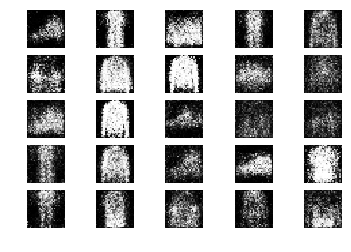

801 [D loss: 0.625783, acc.: 71.88%] [G loss: 0.879111]
802 [D loss: 0.597972, acc.: 75.00%] [G loss: 0.872302]
803 [D loss: 0.647827, acc.: 64.06%] [G loss: 0.880454]
804 [D loss: 0.587037, acc.: 65.62%] [G loss: 0.959774]
805 [D loss: 0.649737, acc.: 65.62%] [G loss: 0.941903]
806 [D loss: 0.710790, acc.: 45.31%] [G loss: 0.869691]
807 [D loss: 0.614725, acc.: 68.75%] [G loss: 0.885718]
808 [D loss: 0.631354, acc.: 67.19%] [G loss: 0.979718]
809 [D loss: 0.613994, acc.: 67.19%] [G loss: 0.966429]
810 [D loss: 0.614461, acc.: 64.06%] [G loss: 0.869304]
811 [D loss: 0.623432, acc.: 70.31%] [G loss: 0.890334]
812 [D loss: 0.599436, acc.: 62.50%] [G loss: 0.913534]
813 [D loss: 0.632682, acc.: 64.06%] [G loss: 0.862987]
814 [D loss: 0.630805, acc.: 60.94%] [G loss: 0.882297]
815 [D loss: 0.658960, acc.: 59.38%] [G loss: 0.931215]
816 [D loss: 0.576101, acc.: 71.88%] [G loss: 0.845074]
817 [D loss: 0.636202, acc.: 64.06%] [G loss: 0.923000]
818 [D loss: 0.590188, acc.: 62.50%] [G loss: 0.

954 [D loss: 0.583321, acc.: 68.75%] [G loss: 0.959870]
955 [D loss: 0.651051, acc.: 62.50%] [G loss: 0.937041]
956 [D loss: 0.687199, acc.: 53.12%] [G loss: 0.906498]
957 [D loss: 0.595067, acc.: 73.44%] [G loss: 0.897980]
958 [D loss: 0.656937, acc.: 56.25%] [G loss: 0.934938]
959 [D loss: 0.638787, acc.: 60.94%] [G loss: 0.887324]
960 [D loss: 0.761354, acc.: 51.56%] [G loss: 0.908639]
961 [D loss: 0.578281, acc.: 71.88%] [G loss: 0.845605]
962 [D loss: 0.617090, acc.: 71.88%] [G loss: 0.982971]
963 [D loss: 0.633464, acc.: 62.50%] [G loss: 0.979392]
964 [D loss: 0.598108, acc.: 68.75%] [G loss: 0.955251]
965 [D loss: 0.604307, acc.: 67.19%] [G loss: 1.001701]
966 [D loss: 0.639908, acc.: 64.06%] [G loss: 0.844316]
967 [D loss: 0.609046, acc.: 64.06%] [G loss: 0.901442]
968 [D loss: 0.626561, acc.: 64.06%] [G loss: 0.767871]
969 [D loss: 0.643658, acc.: 56.25%] [G loss: 0.866040]
970 [D loss: 0.666091, acc.: 57.81%] [G loss: 0.833610]
971 [D loss: 0.588830, acc.: 64.06%] [G loss: 0.

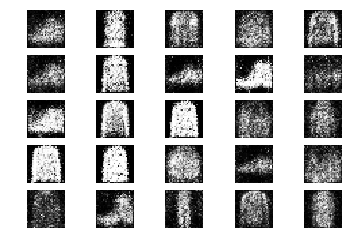

1001 [D loss: 0.641777, acc.: 64.06%] [G loss: 0.826608]
1002 [D loss: 0.606325, acc.: 67.19%] [G loss: 0.865786]
1003 [D loss: 0.646253, acc.: 65.62%] [G loss: 0.882433]
1004 [D loss: 0.610172, acc.: 59.38%] [G loss: 0.919895]
1005 [D loss: 0.610703, acc.: 64.06%] [G loss: 0.946133]
1006 [D loss: 0.566233, acc.: 73.44%] [G loss: 0.900754]
1007 [D loss: 0.586921, acc.: 73.44%] [G loss: 0.926057]
1008 [D loss: 0.567147, acc.: 70.31%] [G loss: 0.946650]
1009 [D loss: 0.728347, acc.: 48.44%] [G loss: 0.949414]
1010 [D loss: 0.546356, acc.: 70.31%] [G loss: 0.878216]
1011 [D loss: 0.680383, acc.: 53.12%] [G loss: 0.803960]
1012 [D loss: 0.596454, acc.: 67.19%] [G loss: 0.888491]
1013 [D loss: 0.610350, acc.: 70.31%] [G loss: 0.841231]
1014 [D loss: 0.641046, acc.: 59.38%] [G loss: 0.891701]
1015 [D loss: 0.611259, acc.: 62.50%] [G loss: 0.777955]
1016 [D loss: 0.567367, acc.: 70.31%] [G loss: 0.814223]
1017 [D loss: 0.616524, acc.: 68.75%] [G loss: 0.879584]
1018 [D loss: 0.622615, acc.: 6

1145 [D loss: 0.651424, acc.: 57.81%] [G loss: 0.937788]
1146 [D loss: 0.682645, acc.: 57.81%] [G loss: 0.885179]
1147 [D loss: 0.615196, acc.: 64.06%] [G loss: 0.879737]
1148 [D loss: 0.614503, acc.: 65.62%] [G loss: 0.857998]
1149 [D loss: 0.695675, acc.: 51.56%] [G loss: 0.846806]
1150 [D loss: 0.638943, acc.: 59.38%] [G loss: 0.906790]
1151 [D loss: 0.657355, acc.: 54.69%] [G loss: 0.864300]
1152 [D loss: 0.667013, acc.: 60.94%] [G loss: 0.948035]
1153 [D loss: 0.594464, acc.: 67.19%] [G loss: 0.878965]
1154 [D loss: 0.657701, acc.: 56.25%] [G loss: 0.855427]
1155 [D loss: 0.644781, acc.: 59.38%] [G loss: 0.889858]
1156 [D loss: 0.571568, acc.: 68.75%] [G loss: 0.930754]
1157 [D loss: 0.603172, acc.: 67.19%] [G loss: 0.954255]
1158 [D loss: 0.596626, acc.: 67.19%] [G loss: 0.956863]
1159 [D loss: 0.620492, acc.: 67.19%] [G loss: 0.910317]
1160 [D loss: 0.638007, acc.: 65.62%] [G loss: 0.949258]
1161 [D loss: 0.670488, acc.: 60.94%] [G loss: 0.861707]
1162 [D loss: 0.624603, acc.: 6

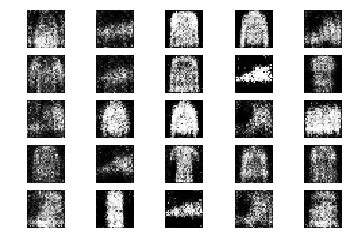

1201 [D loss: 0.591535, acc.: 70.31%] [G loss: 0.833112]
1202 [D loss: 0.632776, acc.: 64.06%] [G loss: 0.888141]
1203 [D loss: 0.641310, acc.: 62.50%] [G loss: 0.913514]
1204 [D loss: 0.635174, acc.: 68.75%] [G loss: 0.911589]
1205 [D loss: 0.567669, acc.: 73.44%] [G loss: 0.942248]
1206 [D loss: 0.631625, acc.: 59.38%] [G loss: 0.885050]
1207 [D loss: 0.690040, acc.: 51.56%] [G loss: 0.905236]
1208 [D loss: 0.680540, acc.: 64.06%] [G loss: 0.841470]
1209 [D loss: 0.622778, acc.: 60.94%] [G loss: 0.862590]
1210 [D loss: 0.644573, acc.: 57.81%] [G loss: 0.899769]
1211 [D loss: 0.567407, acc.: 79.69%] [G loss: 0.876275]
1212 [D loss: 0.672185, acc.: 59.38%] [G loss: 0.888605]
1213 [D loss: 0.657553, acc.: 57.81%] [G loss: 0.878876]
1214 [D loss: 0.627165, acc.: 70.31%] [G loss: 0.873671]
1215 [D loss: 0.567588, acc.: 70.31%] [G loss: 0.833512]
1216 [D loss: 0.675880, acc.: 62.50%] [G loss: 0.849307]
1217 [D loss: 0.656562, acc.: 65.62%] [G loss: 0.817580]
1218 [D loss: 0.639053, acc.: 5

1345 [D loss: 0.594908, acc.: 70.31%] [G loss: 0.849159]
1346 [D loss: 0.596152, acc.: 67.19%] [G loss: 0.904967]
1347 [D loss: 0.629444, acc.: 64.06%] [G loss: 0.973895]
1348 [D loss: 0.648487, acc.: 60.94%] [G loss: 0.938617]
1349 [D loss: 0.653329, acc.: 67.19%] [G loss: 0.966786]
1350 [D loss: 0.628869, acc.: 59.38%] [G loss: 0.928363]
1351 [D loss: 0.624815, acc.: 64.06%] [G loss: 0.917171]
1352 [D loss: 0.661768, acc.: 59.38%] [G loss: 0.942868]
1353 [D loss: 0.593188, acc.: 70.31%] [G loss: 0.788813]
1354 [D loss: 0.663067, acc.: 62.50%] [G loss: 0.863962]
1355 [D loss: 0.682579, acc.: 59.38%] [G loss: 0.856672]
1356 [D loss: 0.647791, acc.: 62.50%] [G loss: 0.849119]
1357 [D loss: 0.621585, acc.: 62.50%] [G loss: 0.869200]
1358 [D loss: 0.576073, acc.: 71.88%] [G loss: 0.911423]
1359 [D loss: 0.630496, acc.: 67.19%] [G loss: 0.874107]
1360 [D loss: 0.639324, acc.: 60.94%] [G loss: 0.856709]
1361 [D loss: 0.558353, acc.: 78.12%] [G loss: 0.928367]
1362 [D loss: 0.603324, acc.: 6

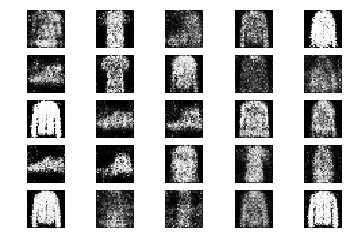

1401 [D loss: 0.654197, acc.: 59.38%] [G loss: 0.914021]
1402 [D loss: 0.622208, acc.: 62.50%] [G loss: 0.904779]
1403 [D loss: 0.609211, acc.: 64.06%] [G loss: 0.825588]
1404 [D loss: 0.602446, acc.: 70.31%] [G loss: 0.830039]
1405 [D loss: 0.594550, acc.: 62.50%] [G loss: 0.927400]
1406 [D loss: 0.516050, acc.: 73.44%] [G loss: 1.007051]
1407 [D loss: 0.600649, acc.: 67.19%] [G loss: 0.898508]
1408 [D loss: 0.631508, acc.: 71.88%] [G loss: 0.834731]
1409 [D loss: 0.603360, acc.: 65.62%] [G loss: 0.870769]
1410 [D loss: 0.617253, acc.: 65.62%] [G loss: 0.898890]
1411 [D loss: 0.586414, acc.: 70.31%] [G loss: 0.956096]
1412 [D loss: 0.644228, acc.: 64.06%] [G loss: 0.942808]
1413 [D loss: 0.617574, acc.: 73.44%] [G loss: 1.072630]
1414 [D loss: 0.563932, acc.: 71.88%] [G loss: 0.985829]
1415 [D loss: 0.600926, acc.: 67.19%] [G loss: 0.973394]
1416 [D loss: 0.660061, acc.: 67.19%] [G loss: 0.962998]
1417 [D loss: 0.575859, acc.: 73.44%] [G loss: 1.016648]
1418 [D loss: 0.640730, acc.: 7

1553 [D loss: 0.659669, acc.: 56.25%] [G loss: 0.916280]
1554 [D loss: 0.697131, acc.: 62.50%] [G loss: 0.884841]
1555 [D loss: 0.691595, acc.: 54.69%] [G loss: 0.927693]
1556 [D loss: 0.583175, acc.: 76.56%] [G loss: 0.906908]
1557 [D loss: 0.652475, acc.: 59.38%] [G loss: 0.823459]
1558 [D loss: 0.569767, acc.: 70.31%] [G loss: 0.872782]
1559 [D loss: 0.570888, acc.: 75.00%] [G loss: 0.977988]
1560 [D loss: 0.750536, acc.: 51.56%] [G loss: 0.962310]
1561 [D loss: 0.648614, acc.: 67.19%] [G loss: 0.902997]
1562 [D loss: 0.603335, acc.: 70.31%] [G loss: 0.934054]
1563 [D loss: 0.649804, acc.: 62.50%] [G loss: 0.913889]
1564 [D loss: 0.571386, acc.: 79.69%] [G loss: 0.927010]
1565 [D loss: 0.587394, acc.: 64.06%] [G loss: 0.925554]
1566 [D loss: 0.701785, acc.: 56.25%] [G loss: 0.941151]
1567 [D loss: 0.621972, acc.: 70.31%] [G loss: 0.950191]
1568 [D loss: 0.614778, acc.: 67.19%] [G loss: 0.918253]
1569 [D loss: 0.616470, acc.: 64.06%] [G loss: 0.889010]
1570 [D loss: 0.627779, acc.: 5

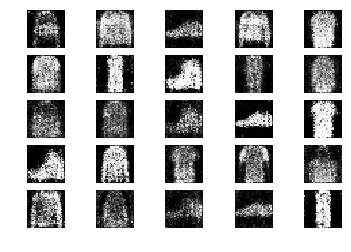

1601 [D loss: 0.641626, acc.: 59.38%] [G loss: 0.915903]
1602 [D loss: 0.587001, acc.: 67.19%] [G loss: 0.883634]
1603 [D loss: 0.752661, acc.: 53.12%] [G loss: 0.903733]
1604 [D loss: 0.641972, acc.: 64.06%] [G loss: 0.932539]
1605 [D loss: 0.596775, acc.: 67.19%] [G loss: 0.798046]
1606 [D loss: 0.613973, acc.: 64.06%] [G loss: 0.888414]
1607 [D loss: 0.628922, acc.: 60.94%] [G loss: 0.830658]
1608 [D loss: 0.691041, acc.: 57.81%] [G loss: 0.925787]
1609 [D loss: 0.643926, acc.: 56.25%] [G loss: 0.908627]
1610 [D loss: 0.646957, acc.: 53.12%] [G loss: 0.903495]
1611 [D loss: 0.561488, acc.: 75.00%] [G loss: 0.939848]
1612 [D loss: 0.658680, acc.: 57.81%] [G loss: 0.855084]
1613 [D loss: 0.621999, acc.: 68.75%] [G loss: 0.968239]
1614 [D loss: 0.610875, acc.: 64.06%] [G loss: 0.888520]
1615 [D loss: 0.618872, acc.: 73.44%] [G loss: 0.808359]
1616 [D loss: 0.603116, acc.: 68.75%] [G loss: 0.915688]
1617 [D loss: 0.620585, acc.: 65.62%] [G loss: 0.972255]
1618 [D loss: 0.621987, acc.: 6

1755 [D loss: 0.552107, acc.: 73.44%] [G loss: 0.890737]
1756 [D loss: 0.657318, acc.: 60.94%] [G loss: 0.859118]
1757 [D loss: 0.600262, acc.: 68.75%] [G loss: 0.872291]
1758 [D loss: 0.643008, acc.: 60.94%] [G loss: 0.944326]
1759 [D loss: 0.632470, acc.: 67.19%] [G loss: 0.973591]
1760 [D loss: 0.645893, acc.: 65.62%] [G loss: 0.853896]
1761 [D loss: 0.674119, acc.: 56.25%] [G loss: 0.887433]
1762 [D loss: 0.576055, acc.: 64.06%] [G loss: 1.063125]
1763 [D loss: 0.592928, acc.: 73.44%] [G loss: 0.968332]
1764 [D loss: 0.663537, acc.: 60.94%] [G loss: 0.894245]
1765 [D loss: 0.657285, acc.: 60.94%] [G loss: 0.894580]
1766 [D loss: 0.663309, acc.: 57.81%] [G loss: 0.863479]
1767 [D loss: 0.657102, acc.: 68.75%] [G loss: 0.939461]
1768 [D loss: 0.647868, acc.: 57.81%] [G loss: 0.907899]
1769 [D loss: 0.651704, acc.: 67.19%] [G loss: 1.013119]
1770 [D loss: 0.617631, acc.: 65.62%] [G loss: 0.935011]
1771 [D loss: 0.685771, acc.: 60.94%] [G loss: 0.861255]
1772 [D loss: 0.645746, acc.: 6

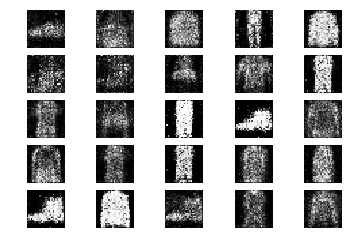

1801 [D loss: 0.616640, acc.: 65.62%] [G loss: 1.008482]
1802 [D loss: 0.630316, acc.: 59.38%] [G loss: 0.901849]
1803 [D loss: 0.667469, acc.: 53.12%] [G loss: 0.974668]
1804 [D loss: 0.632399, acc.: 64.06%] [G loss: 0.874580]
1805 [D loss: 0.569132, acc.: 70.31%] [G loss: 0.926540]
1806 [D loss: 0.601607, acc.: 75.00%] [G loss: 0.975677]
1807 [D loss: 0.635424, acc.: 65.62%] [G loss: 0.908572]
1808 [D loss: 0.601534, acc.: 64.06%] [G loss: 0.886142]
1809 [D loss: 0.652986, acc.: 56.25%] [G loss: 0.926444]
1810 [D loss: 0.564664, acc.: 70.31%] [G loss: 0.942159]
1811 [D loss: 0.656631, acc.: 59.38%] [G loss: 0.877499]
1812 [D loss: 0.560385, acc.: 68.75%] [G loss: 0.927914]
1813 [D loss: 0.569257, acc.: 67.19%] [G loss: 0.921562]
1814 [D loss: 0.654011, acc.: 57.81%] [G loss: 0.871034]
1815 [D loss: 0.603242, acc.: 73.44%] [G loss: 0.821567]
1816 [D loss: 0.598513, acc.: 67.19%] [G loss: 0.960851]
1817 [D loss: 0.620622, acc.: 65.62%] [G loss: 0.930215]
1818 [D loss: 0.600986, acc.: 6

1955 [D loss: 0.720832, acc.: 48.44%] [G loss: 0.969226]
1956 [D loss: 0.580941, acc.: 70.31%] [G loss: 0.979586]
1957 [D loss: 0.641111, acc.: 57.81%] [G loss: 0.887139]
1958 [D loss: 0.611888, acc.: 70.31%] [G loss: 0.912688]
1959 [D loss: 0.569615, acc.: 78.12%] [G loss: 1.037651]
1960 [D loss: 0.652875, acc.: 60.94%] [G loss: 0.919390]
1961 [D loss: 0.659721, acc.: 59.38%] [G loss: 0.946096]
1962 [D loss: 0.569004, acc.: 73.44%] [G loss: 0.901250]
1963 [D loss: 0.658913, acc.: 59.38%] [G loss: 0.886424]
1964 [D loss: 0.567630, acc.: 71.88%] [G loss: 0.926978]
1965 [D loss: 0.629013, acc.: 59.38%] [G loss: 0.898106]
1966 [D loss: 0.502760, acc.: 78.12%] [G loss: 0.919231]
1967 [D loss: 0.687386, acc.: 59.38%] [G loss: 0.890039]
1968 [D loss: 0.747450, acc.: 48.44%] [G loss: 0.838403]
1969 [D loss: 0.600954, acc.: 75.00%] [G loss: 0.802051]
1970 [D loss: 0.588691, acc.: 68.75%] [G loss: 0.965024]
1971 [D loss: 0.619002, acc.: 70.31%] [G loss: 0.930105]
1972 [D loss: 0.587462, acc.: 7

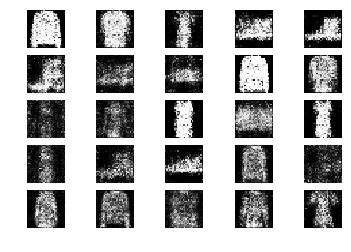

2001 [D loss: 0.688347, acc.: 59.38%] [G loss: 0.963133]
2002 [D loss: 0.675625, acc.: 59.38%] [G loss: 1.002412]
2003 [D loss: 0.542459, acc.: 71.88%] [G loss: 1.131151]
2004 [D loss: 0.579258, acc.: 71.88%] [G loss: 0.947583]
2005 [D loss: 0.543595, acc.: 68.75%] [G loss: 1.031708]
2006 [D loss: 0.614185, acc.: 67.19%] [G loss: 0.831072]
2007 [D loss: 0.629067, acc.: 64.06%] [G loss: 0.998506]
2008 [D loss: 0.625748, acc.: 65.62%] [G loss: 0.908784]
2009 [D loss: 0.588498, acc.: 75.00%] [G loss: 0.965763]
2010 [D loss: 0.619823, acc.: 67.19%] [G loss: 0.972396]
2011 [D loss: 0.602222, acc.: 73.44%] [G loss: 0.939192]
2012 [D loss: 0.645356, acc.: 65.62%] [G loss: 0.910958]
2013 [D loss: 0.646593, acc.: 59.38%] [G loss: 1.035849]
2014 [D loss: 0.587622, acc.: 65.62%] [G loss: 1.017052]
2015 [D loss: 0.651219, acc.: 59.38%] [G loss: 1.015649]
2016 [D loss: 0.575952, acc.: 67.19%] [G loss: 0.869850]
2017 [D loss: 0.648719, acc.: 60.94%] [G loss: 0.919920]
2018 [D loss: 0.565622, acc.: 7

2153 [D loss: 0.643480, acc.: 56.25%] [G loss: 0.884623]
2154 [D loss: 0.623307, acc.: 62.50%] [G loss: 0.871581]
2155 [D loss: 0.712755, acc.: 46.88%] [G loss: 0.895395]
2156 [D loss: 0.627777, acc.: 67.19%] [G loss: 0.937969]
2157 [D loss: 0.600246, acc.: 68.75%] [G loss: 0.922461]
2158 [D loss: 0.588765, acc.: 68.75%] [G loss: 0.983409]
2159 [D loss: 0.603100, acc.: 73.44%] [G loss: 0.952627]
2160 [D loss: 0.599150, acc.: 70.31%] [G loss: 0.931924]
2161 [D loss: 0.603382, acc.: 70.31%] [G loss: 0.875162]
2162 [D loss: 0.600079, acc.: 75.00%] [G loss: 0.928783]
2163 [D loss: 0.660668, acc.: 56.25%] [G loss: 0.899007]
2164 [D loss: 0.601476, acc.: 68.75%] [G loss: 0.945191]
2165 [D loss: 0.636948, acc.: 62.50%] [G loss: 0.884491]
2166 [D loss: 0.649249, acc.: 60.94%] [G loss: 0.995341]
2167 [D loss: 0.659729, acc.: 62.50%] [G loss: 0.915249]
2168 [D loss: 0.664973, acc.: 53.12%] [G loss: 0.961370]
2169 [D loss: 0.592206, acc.: 65.62%] [G loss: 0.857715]
2170 [D loss: 0.596131, acc.: 6

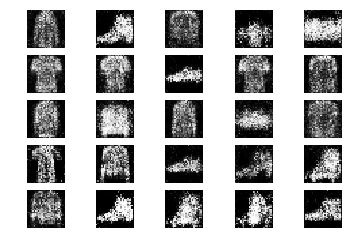

2201 [D loss: 0.621300, acc.: 67.19%] [G loss: 0.904697]
2202 [D loss: 0.676825, acc.: 64.06%] [G loss: 0.887285]
2203 [D loss: 0.619757, acc.: 67.19%] [G loss: 0.933286]
2204 [D loss: 0.624037, acc.: 60.94%] [G loss: 0.968648]
2205 [D loss: 0.640596, acc.: 67.19%] [G loss: 0.948076]
2206 [D loss: 0.631500, acc.: 62.50%] [G loss: 0.942459]
2207 [D loss: 0.592324, acc.: 65.62%] [G loss: 1.014285]
2208 [D loss: 0.627042, acc.: 70.31%] [G loss: 0.968730]
2209 [D loss: 0.579421, acc.: 70.31%] [G loss: 0.825568]
2210 [D loss: 0.584459, acc.: 67.19%] [G loss: 0.964092]
2211 [D loss: 0.532515, acc.: 79.69%] [G loss: 1.002863]
2212 [D loss: 0.654079, acc.: 59.38%] [G loss: 0.913879]
2213 [D loss: 0.671734, acc.: 54.69%] [G loss: 0.930082]
2214 [D loss: 0.613380, acc.: 73.44%] [G loss: 0.953226]
2215 [D loss: 0.634495, acc.: 64.06%] [G loss: 0.918052]
2216 [D loss: 0.610930, acc.: 65.62%] [G loss: 0.976870]
2217 [D loss: 0.568086, acc.: 75.00%] [G loss: 0.890207]
2218 [D loss: 0.623287, acc.: 6

2354 [D loss: 0.635476, acc.: 62.50%] [G loss: 0.790507]
2355 [D loss: 0.634370, acc.: 62.50%] [G loss: 0.936945]
2356 [D loss: 0.578510, acc.: 73.44%] [G loss: 1.011472]
2357 [D loss: 0.583770, acc.: 68.75%] [G loss: 1.021951]
2358 [D loss: 0.639934, acc.: 64.06%] [G loss: 0.986775]
2359 [D loss: 0.676106, acc.: 57.81%] [G loss: 0.954306]
2360 [D loss: 0.569497, acc.: 70.31%] [G loss: 0.900821]
2361 [D loss: 0.641992, acc.: 62.50%] [G loss: 0.978454]
2362 [D loss: 0.631340, acc.: 59.38%] [G loss: 0.990374]
2363 [D loss: 0.602267, acc.: 70.31%] [G loss: 0.905760]
2364 [D loss: 0.554207, acc.: 76.56%] [G loss: 0.954338]
2365 [D loss: 0.503212, acc.: 79.69%] [G loss: 1.001908]
2366 [D loss: 0.676911, acc.: 59.38%] [G loss: 0.947033]
2367 [D loss: 0.631088, acc.: 62.50%] [G loss: 0.954177]
2368 [D loss: 0.639434, acc.: 54.69%] [G loss: 0.846824]
2369 [D loss: 0.579032, acc.: 67.19%] [G loss: 0.950785]
2370 [D loss: 0.618212, acc.: 68.75%] [G loss: 0.971736]
2371 [D loss: 0.612363, acc.: 6

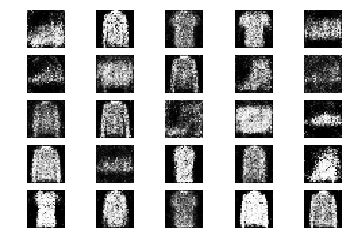

2401 [D loss: 0.630399, acc.: 64.06%] [G loss: 0.867060]
2402 [D loss: 0.595300, acc.: 64.06%] [G loss: 0.834441]
2403 [D loss: 0.575736, acc.: 70.31%] [G loss: 0.921459]
2404 [D loss: 0.584306, acc.: 70.31%] [G loss: 0.983275]
2405 [D loss: 0.600344, acc.: 76.56%] [G loss: 0.962856]
2406 [D loss: 0.643123, acc.: 67.19%] [G loss: 0.933334]
2407 [D loss: 0.622123, acc.: 62.50%] [G loss: 0.891240]
2408 [D loss: 0.614197, acc.: 68.75%] [G loss: 0.827243]
2409 [D loss: 0.673838, acc.: 67.19%] [G loss: 0.927312]
2410 [D loss: 0.587040, acc.: 68.75%] [G loss: 0.836033]
2411 [D loss: 0.619767, acc.: 60.94%] [G loss: 1.004303]
2412 [D loss: 0.623654, acc.: 67.19%] [G loss: 0.955015]
2413 [D loss: 0.585807, acc.: 65.62%] [G loss: 0.911696]
2414 [D loss: 0.563704, acc.: 73.44%] [G loss: 0.859641]
2415 [D loss: 0.637943, acc.: 56.25%] [G loss: 0.988702]
2416 [D loss: 0.621976, acc.: 64.06%] [G loss: 0.872057]
2417 [D loss: 0.583497, acc.: 71.88%] [G loss: 0.932246]
2418 [D loss: 0.627796, acc.: 6

2554 [D loss: 0.618927, acc.: 64.06%] [G loss: 1.126312]
2555 [D loss: 0.608780, acc.: 68.75%] [G loss: 0.929436]
2556 [D loss: 0.611665, acc.: 62.50%] [G loss: 0.959963]
2557 [D loss: 0.573723, acc.: 78.12%] [G loss: 0.916733]
2558 [D loss: 0.593012, acc.: 73.44%] [G loss: 0.999218]
2559 [D loss: 0.603095, acc.: 70.31%] [G loss: 0.996759]
2560 [D loss: 0.616433, acc.: 64.06%] [G loss: 0.917192]
2561 [D loss: 0.596724, acc.: 64.06%] [G loss: 0.932529]
2562 [D loss: 0.593773, acc.: 64.06%] [G loss: 0.983889]
2563 [D loss: 0.639197, acc.: 57.81%] [G loss: 1.026875]
2564 [D loss: 0.666805, acc.: 53.12%] [G loss: 0.987702]
2565 [D loss: 0.638330, acc.: 67.19%] [G loss: 0.944963]
2566 [D loss: 0.642115, acc.: 57.81%] [G loss: 1.012069]
2567 [D loss: 0.568509, acc.: 71.88%] [G loss: 0.987676]
2568 [D loss: 0.622374, acc.: 67.19%] [G loss: 1.043127]
2569 [D loss: 0.609042, acc.: 67.19%] [G loss: 0.965367]
2570 [D loss: 0.548822, acc.: 78.12%] [G loss: 0.965941]
2571 [D loss: 0.656929, acc.: 6

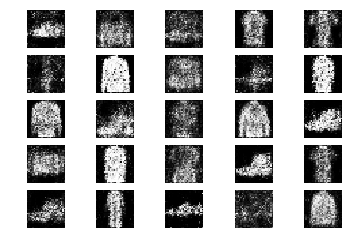

2601 [D loss: 0.603589, acc.: 67.19%] [G loss: 1.045413]
2602 [D loss: 0.613013, acc.: 59.38%] [G loss: 1.017494]
2603 [D loss: 0.639863, acc.: 65.62%] [G loss: 0.930417]
2604 [D loss: 0.616414, acc.: 60.94%] [G loss: 0.982170]
2605 [D loss: 0.691103, acc.: 51.56%] [G loss: 0.942853]
2606 [D loss: 0.659052, acc.: 60.94%] [G loss: 0.953739]
2607 [D loss: 0.597596, acc.: 65.62%] [G loss: 0.965122]
2608 [D loss: 0.529858, acc.: 82.81%] [G loss: 1.052440]
2609 [D loss: 0.694519, acc.: 60.94%] [G loss: 1.006711]
2610 [D loss: 0.601340, acc.: 70.31%] [G loss: 1.073118]
2611 [D loss: 0.604361, acc.: 68.75%] [G loss: 0.915844]
2612 [D loss: 0.582430, acc.: 68.75%] [G loss: 0.935746]
2613 [D loss: 0.669678, acc.: 59.38%] [G loss: 0.849543]
2614 [D loss: 0.625413, acc.: 64.06%] [G loss: 0.952276]
2615 [D loss: 0.631792, acc.: 64.06%] [G loss: 1.021668]
2616 [D loss: 0.560026, acc.: 70.31%] [G loss: 0.879282]
2617 [D loss: 0.587161, acc.: 73.44%] [G loss: 0.932962]
2618 [D loss: 0.750648, acc.: 5

2755 [D loss: 0.608877, acc.: 59.38%] [G loss: 0.974514]
2756 [D loss: 0.593498, acc.: 71.88%] [G loss: 0.998422]
2757 [D loss: 0.646756, acc.: 60.94%] [G loss: 1.111759]
2758 [D loss: 0.620840, acc.: 67.19%] [G loss: 1.033327]
2759 [D loss: 0.673164, acc.: 62.50%] [G loss: 0.974910]
2760 [D loss: 0.616817, acc.: 65.62%] [G loss: 0.976863]
2761 [D loss: 0.651791, acc.: 62.50%] [G loss: 1.038097]
2762 [D loss: 0.624446, acc.: 62.50%] [G loss: 0.931330]
2763 [D loss: 0.676673, acc.: 60.94%] [G loss: 0.923453]
2764 [D loss: 0.623773, acc.: 67.19%] [G loss: 0.857205]
2765 [D loss: 0.589785, acc.: 68.75%] [G loss: 0.879470]
2766 [D loss: 0.582051, acc.: 64.06%] [G loss: 0.841734]
2767 [D loss: 0.632975, acc.: 65.62%] [G loss: 0.784447]
2768 [D loss: 0.603151, acc.: 64.06%] [G loss: 0.882989]
2769 [D loss: 0.693265, acc.: 60.94%] [G loss: 1.001812]
2770 [D loss: 0.587887, acc.: 70.31%] [G loss: 0.855457]
2771 [D loss: 0.655014, acc.: 60.94%] [G loss: 0.930932]
2772 [D loss: 0.590335, acc.: 7

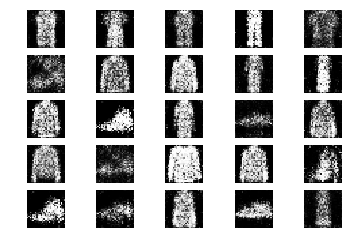

2801 [D loss: 0.595069, acc.: 70.31%] [G loss: 1.012412]
2802 [D loss: 0.629989, acc.: 62.50%] [G loss: 0.977065]
2803 [D loss: 0.587015, acc.: 65.62%] [G loss: 0.963903]
2804 [D loss: 0.592010, acc.: 62.50%] [G loss: 1.035864]
2805 [D loss: 0.669910, acc.: 57.81%] [G loss: 0.940130]
2806 [D loss: 0.565380, acc.: 71.88%] [G loss: 0.923726]
2807 [D loss: 0.629979, acc.: 60.94%] [G loss: 0.921116]
2808 [D loss: 0.622568, acc.: 62.50%] [G loss: 0.943681]
2809 [D loss: 0.596031, acc.: 62.50%] [G loss: 0.977169]
2810 [D loss: 0.532243, acc.: 73.44%] [G loss: 1.039740]
2811 [D loss: 0.656913, acc.: 60.94%] [G loss: 1.031634]
2812 [D loss: 0.641822, acc.: 62.50%] [G loss: 1.019901]
2813 [D loss: 0.645516, acc.: 54.69%] [G loss: 0.999444]
2814 [D loss: 0.670834, acc.: 56.25%] [G loss: 0.908317]
2815 [D loss: 0.598895, acc.: 64.06%] [G loss: 0.979113]
2816 [D loss: 0.702606, acc.: 57.81%] [G loss: 0.917290]
2817 [D loss: 0.648257, acc.: 59.38%] [G loss: 0.877676]
2818 [D loss: 0.684861, acc.: 5

2954 [D loss: 0.643054, acc.: 56.25%] [G loss: 0.952553]
2955 [D loss: 0.607892, acc.: 60.94%] [G loss: 0.997676]
2956 [D loss: 0.599743, acc.: 59.38%] [G loss: 0.967253]
2957 [D loss: 0.570729, acc.: 67.19%] [G loss: 0.980325]
2958 [D loss: 0.593687, acc.: 68.75%] [G loss: 0.991902]
2959 [D loss: 0.571809, acc.: 60.94%] [G loss: 0.890437]
2960 [D loss: 0.600626, acc.: 65.62%] [G loss: 0.901124]
2961 [D loss: 0.570013, acc.: 68.75%] [G loss: 0.927236]
2962 [D loss: 0.641705, acc.: 67.19%] [G loss: 0.871832]
2963 [D loss: 0.601027, acc.: 70.31%] [G loss: 0.946291]
2964 [D loss: 0.609771, acc.: 65.62%] [G loss: 0.967174]
2965 [D loss: 0.616506, acc.: 64.06%] [G loss: 0.951568]
2966 [D loss: 0.637513, acc.: 64.06%] [G loss: 0.922137]
2967 [D loss: 0.583899, acc.: 70.31%] [G loss: 0.939778]
2968 [D loss: 0.686650, acc.: 54.69%] [G loss: 0.961378]
2969 [D loss: 0.653210, acc.: 53.12%] [G loss: 0.919458]
2970 [D loss: 0.599297, acc.: 71.88%] [G loss: 0.859061]
2971 [D loss: 0.652346, acc.: 5

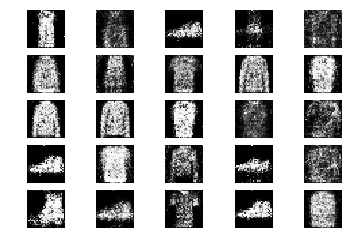

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)